<a href="https://colab.research.google.com/github/stupidbutsmart/DELE-CA1/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
  b {
    color: red;
  }
</style>

## Section A CA1 CNN

Name: Jovan Heng Ghim Hong

Class: DAAA/2B/22

Admin No: 2401418

In [30]:
# Basic Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten ,Conv2D, MaxPooling2D , UpSampling2D, Cropping2D, ReLU, BatchNormalization, Dropout
from sklearn.model_selection import RandomizedSearchCV,ParameterGrid, train_test_split
from sklearn.ensemble import IsolationForest
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

## for keras classifier i will be using scikeras lib
## 2.12+ no longer supports tensorflow.keras.wrappers.scikit_learn
## this was coded in across different versions (namely 2.10 and 2.19)
from scikeras.wrappers import KerasClassifier


tf.random.set_seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')

### Creating UDFs to aid workflow

Before i start, i want to create some functions that can help me with my work.

basic functions like:
1. create model function
2. autoencoder function
3. data processing functions

etc.

This can help modularize my code (especially since im working with 2 models) and make it easier for future collaborater to understand

In [4]:
DATASET_PATH = './datasets/'

def get_greyscale_data(data_type , size):
  targets = [ target for target in os.listdir(DATASET_PATH + data_type)]

  rows = []
  for target in targets: 
    for file_name in os.listdir(os.path.join(DATASET_PATH , data_type ,  target)):
      # greyscale 
      img = image.load_img(os.path.join(DATASET_PATH , data_type, target , file_name ) ,color_mode='grayscale' , target_size=size)
      img = image.img_to_array(img) / 255.0 # divide by 255 to normalize it
      
      record = {'sequence' : img}
      for t in targets:
        record[t] = 1 if t == target else 0

      rows.append(record)

  return pd.DataFrame(rows , columns=['sequence'] + targets)



In [5]:
STORED_DATA = './stored_data/'
def build_raw_data(size):
  """ size should be a single number n for n x n pixels
  """
  res = []
  for file in os.listdir(STORED_DATA):
    if file.endswith('23.json') and (str (size) in file):
      res.append(pd.read_json(os.path.join(STORED_DATA , file)))
  return res

In [6]:
# def create_model(
#     number_of_layers=3 , number_of_neurons=128,
#     optimizer='adam' , activation='relu',
#     layers=[Conv2D], # incase i want to add more layers
#     strict_follow_layers = False,
#     input_shape=(23 , 23 , 1) # follows first layer
# ):
#   model = Sequential()

#   # Adding layers
#   if strict_follow_layers:
#     for layer in layers:
#       model.add(layer(number_of_neurons , activation=activation))
#   else:
#     for i in range(number_of_layers):
#       for layer in layers:
#         model.add(layer(number_of_neurons , activation=activation))

#   model.add(Flatten())
#   model.add(Dense(1 , activation='softmax'))
#   model.compile(optimizer=optimizer , loss='categorical_crossentropy' , metrics=['accuracy'])

#   return KerasClassifier(model)



### Data Cleaning and Exploration

In [16]:
## NOTE
## get_greyscale_data() takes awhile to run
## below there is a function that builds the DF from ./stored_data
## run if ./stored_data was not provided, otherwise run cell with build_data() below
train_data = get_greyscale_data('train' , (23 , 23))

In [17]:
train_data.head()

,sequence,Bean,Bitter_Gourd,Brinjal,Cabbage,Capsicum,Cauliflower and Broccoli,Cucumber and Bottle_Gourd,Potato,Pumpkin,Radish and Carrot,Tomato
0,"[[[0.13333334], [0.41960785], [0.1254902], [0....",1,0,0,0,0,0,0,0,0,0,0
1,"[[[0.7411765], [0.7372549], [0.7294118], [0.72...",1,0,0,0,0,0,0,0,0,0,0
2,"[[[0.44705883], [0.41960785], [0.3647059], [0....",1,0,0,0,0,0,0,0,0,0,0
3,"[[[0.20784314], [0.21568628], [0.16470589], [0...",1,0,0,0,0,0,0,0,0,0,0
4,"[[[0.63529414], [0.64705884], [0.65882355], [0...",1,0,0,0,0,0,0,0,0,0,0


In order to save computional time, we will save the data, allowing us to build our df from it.

We are using json format, as integrates seamlessly with my **sequence** column

In [18]:
train_data.to_json(os.path.join(STORED_DATA , 'train_23.json') , orient='records')

## repeat for test and validation
test_data = get_greyscale_data('test' , (23 , 23))
validation_data = get_greyscale_data('validation' , (23 , 23))

test_data.to_json(os.path.join(STORED_DATA , 'test_23.json') , orient='records')
validation_data.to_json(os.path.join(STORED_DATA , 'validation_23.json') , orient='records')

With our data exported, we can reimport it 

In [7]:
test_data , train_data , validation_data = build_raw_data(23)

In [8]:
train_data.head()

,sequence,Bean,Bitter_Gourd,Brinjal,Cabbage,Capsicum,Cauliflower and Broccoli,Cucumber and Bottle_Gourd,Potato,Pumpkin,Radish and Carrot,Tomato
0,"[[[0.1333333403], [0.4196078479], [0.125490203...",1,0,0,0,0,0,0,0,0,0,0
1,"[[[0.7411764860000001], [0.7372549176000001], ...",1,0,0,0,0,0,0,0,0,0,0
2,"[[[0.4470588267], [0.4196078479], [0.364705890...",1,0,0,0,0,0,0,0,0,0,0
3,"[[[0.20784313980000002], [0.2156862766], [0.16...",1,0,0,0,0,0,0,0,0,0,0
4,"[[[0.6352941394], [0.6470588446000001], [0.658...",1,0,0,0,0,0,0,0,0,0,0


We can recontruct it and plot it using matplotlib 

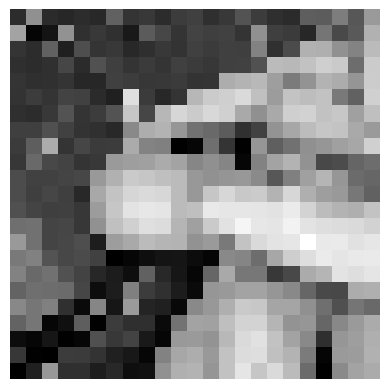

In [9]:
plt.imshow(train_data['sequence'].iloc[0] , cmap='gray')
plt.axis('off')
plt.show()

##### Comparing it to its real img counterpart
<style>
.two_col_row {
  display: grid;
  grid-template-columns: 1fr 1fr; /* Two equal columns */
  gap: 20px; /* Space between items */
  padding: 20px
}

img {
  height: auto;
  width: 100%;
}



  </style>
<div class='two_col_row'>
  <img src='./markdown/bean_1_reconstruction.png'>
  <img src='./markdown/bean_1_original.jpg'>
</div>




Simply from the first image of **Bean**, it is already not a bean but a **carrot**

Manual Inspection of the **training** data shows that there is a **large majority of beans** in the bean dataset but there are **a small amount of mislabelled vegetables**

##### Solution? 

We are going to **create an autoencoder** and **use the bottleneck to detect abnomalies**

In [8]:
train_data.shape

(7710, 12)

In [9]:
# Creating the autoencoder
# We do not need to tune this encoder, we want to keep it simple (generalize well)

def generate_autoencoder():
  autoencoder = Sequential([
    # encoding part
    Conv2D(filters=128 , kernel_size=(3 , 3) , activation='relu' , input_shape=(23 , 23 , 1), padding='same'),
    MaxPooling2D((2 , 2), padding='same'),
    Conv2D(filters=32 , kernel_size=(3 , 3) , activation='relu', padding='same'), # bottleneck / compressed layer (32 features)
    MaxPooling2D((2 , 2), padding='same'),
    # decoding part
    Conv2D(filters=32 , kernel_size=(3 , 3) , activation='relu', padding='same'),
    UpSampling2D((2 , 2)),
    Conv2D(filters=128, kernel_size=(3 , 3) , activation='relu', padding='same'),
    UpSampling2D((2 , 2)),
    Cropping2D(cropping=((0,1) , (0,1))), # ensures output is 23x23
    Conv2D(filters=1 , kernel_size=(3 , 3) , activation='sigmoid', padding='same') # output layer
  ])
  return autoencoder

In [10]:
autoencoder = generate_autoencoder()
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        36896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 12, 12, 32)       0

In [13]:
# The idea now is to fit the autoencoder data for each class
# then we can predict back on the data that is is trained.
# it will detect anomalies that we can flag when plotted out (reconstruction error)
# for each class we will also do anomaly detection with sklearn isolation forest 
# NOTE:
# This takes a while, there is a cell below that exports the data
# You only need to run this cell if the exported data does not exist

classes = train_data.columns[1:]

cleaned_train_data = pd.DataFrame(columns=train_data.columns)

for c in classes:
  print(f'Cleaning class {c}...')

  # segmenting the data via classes
  class_data = train_data[train_data[c] == 1].copy()
  X_train = np.stack(class_data['sequence'])

  # anomaly detection with isolation forest
  iso_forest = IsolationForest(contamination=0.025,n_estimators=300 , random_state=14) # expecting roughly 5% outliers
  iso_outliers = iso_forest.fit_predict(X_train.reshape(X_train.shape[0] , -1))

  # fitting on autoencoder
  autoencoder = generate_autoencoder()
  autoencoder.compile(loss='binary_crossentropy' , optimizer='adam')
  autoencoder.fit(X_train , X_train, epochs=20, verbose=0)

  autoencoder_predictions = autoencoder.predict(X_train)

  # calculating reconstruction error
  reconstruction_errors = np.mean(np.abs(autoencoder_predictions - X_train) , axis=(1 , 2 , 3))
  autoencoder_outliers = (reconstruction_errors > np.percentile(reconstruction_errors , 97.5)).astype(int)
  
  print(f'Isolation Forest Result: {np.where(iso_outliers == -1)}')
  print(f'Autoencoder Result: {np.where(autoencoder_outliers == 1)}')
  print()

  # Getting rows that fit both 
  class_data['anomalous'] = (iso_outliers == -1) | (autoencoder_outliers == 1) # returns 1 if anomalous


  # Dropping
  cleaned = class_data[class_data['anomalous'] == 0]
  
  # Storage
  cleaned_train_data = pd.concat([cleaned_train_data, cleaned], axis=0 ,ignore_index=True)
  print('====================================================================')
  
## Writing to Storage
cleaned_train_data.to_json(os.path.join(STORED_DATA , 'cleaned_data', 'train_23_cleaned.json') , orient='records')

Cleaning class Bean...
25/25 [==============================] - 0s 8ms/step
Isolation Forest Result: (array([ 80,  91, 122, 247, 249, 265, 300, 354, 400, 409, 454, 498, 531,
       575, 644, 684, 688, 691, 761, 781], dtype=int64),)
Autoencoder Result: (array([ 42,  87,  89, 112, 142, 181, 247, 248, 293, 306, 332, 380, 402,
       449, 531, 532, 602, 611, 629, 653], dtype=int64),)

Cleaning class Bitter_Gourd...
23/23 [==============================] - 0s 8ms/step
Isolation Forest Result: (array([  1,  57,  67, 134, 149, 180, 196, 240, 292, 312, 344, 362, 383,
       436, 515, 621, 649, 656], dtype=int64),)
Autoencoder Result: (array([ 36,  67, 108, 134, 152, 333, 343, 378, 386, 415, 436, 450, 479,
       526, 575, 621, 694, 696], dtype=int64),)

Cleaning class Brinjal...
28/28 [==============================] - 0s 7ms/step
Isolation Forest Result: (array([ 10,  68,  82, 100, 105, 199, 228, 248, 249, 271, 289, 364, 375,
       385, 407, 484, 577, 615, 671, 743, 747, 857], dtype=int64),)

In [10]:
# Now we can just run this cell instead of 
cleaned_train_data = pd.read_json(os.path.join(STORED_DATA , './cleaned_data/' ,'train_23_cleaned.json'))
print(f'Shape: {cleaned_train_data.shape}')
cleaned_train_data.head(3)

Shape: (7331, 13)


,sequence,Bean,Bitter_Gourd,Brinjal,Cabbage,Capsicum,Cauliflower and Broccoli,Cucumber and Bottle_Gourd,Potato,Pumpkin,Radish and Carrot,Tomato,anomalous
0,"[[[0.1333333403], [0.4196078479], [0.125490203...",1,0,0,0,0,0,0,0,0,0,0,False
1,"[[[0.7411764860000001], [0.7372549176000001], ...",1,0,0,0,0,0,0,0,0,0,0,False
2,"[[[0.4470588267], [0.4196078479], [0.364705890...",1,0,0,0,0,0,0,0,0,0,0,False


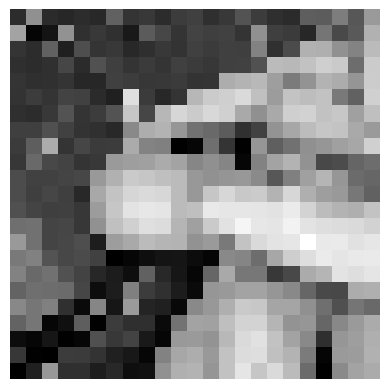

In [11]:
# SImple way to check is to look at the first item
plt.imshow(cleaned_train_data['sequence'].iloc[0], cmap='gray')
plt.axis('off')
plt.show()

##### Creating Model

The Idea behind my model is going to be as follows:

1. Input Layer
2. Conv2d * **n** amounts
3. BatchNormalize
4. Activation Relu
5. Maxpooling/bottleneck layer
6. Flatten
7. Dense - softmax (we are doing multiclass-classification)

where layers 2-5 can be repeated **m** times.

In [12]:
def create_model(n , m, max_neurons , 
            dropout, kernel_size, strides, padding, activation,
            bottleneck
                 ):
  model = Sequential()

  # we want the neurons to be increasing, getting more complex further in
  neurons_arr = [32] # starting
  for _ in range(m -1 ):
    neurons_arr.append(min(neurons_arr[len(neurons_arr) - 1] * 2 ,  max_neurons))
  
  for i in range(m):
    # Adding n number of conv2d
    for ii in range(n):
      model.add(Conv2D(neurons_arr[i], kernel_size, strides=strides, padding=padding))

    model.add(BatchNormalization())
    model.add(activation)
    model.add(bottleneck)
  
  model.add(Dropout(dropout))
  model.add(Flatten())
  model.add(Dense(11 , activation='softmax'))
  model.compile(loss='categorical_crossentropy' , optimizer='adam' , metrics=['accuracy'])
  return model
 
  


In [13]:
X_train = np.stack(cleaned_train_data['sequence'])
y_train = cleaned_train_data.drop(columns=['sequence' , 'anomalous']).values.astype(float)

X_test = np.stack(test_data['sequence'])
y_test = test_data.drop(columns=['sequence']).values

X_validation = np.stack(validation_data['sequence'])
y_validation = validation_data.drop(columns=['sequence']).values.astype(float)

In [ ]:
hyper_params = { 
  'n': np.arange(1 , 4),
  'm': np.arange(1 , 3),
  'max_neurons':  [32 , 64 , 128 , 256],
  'dropout': np.linspace(0.1 , 0.25, 3),
  'strides': [(1 , 1)],
  'padding': ['valid' , 'same'],
  'activation': [ReLU()],
  'bottleneck': [MaxPooling2D()],
  'kernel_size': [(3 , 3) , (5 , 5) , (7, 7)]
}

val_losses = []
val_accuracies = []
fit_results = []
successful_params = []


In [15]:

# Grid Search
for params in list(ParameterGrid(hyper_params)):
  try:
    print(f'Tuning for {params}... ')

    # Create and fit
    model = create_model(**params)
    early_stop = EarlyStopping(monitor='val_loss' , patience=5 , restore_best_weights=True)
    fit_result = model.fit(X_train, y_train, epochs=100 , 
              batch_size=16, 
              validation_data=(X_validation , y_validation) 
              , callbacks=[early_stop]
              ,verbose = 0
              )

    # Eval and store 
    # will not be using cross val score since we have dedicated vaildation data.
    val_loss , val_accuracy = model.evaluate(X_validation , y_validation)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    fit_results.append(fit_result.history)
    successful_params.append(params) # this is required since im skipping bad params

    print(f'Val loss: {val_loss} , val_accuracy: {val_accuracy}')
  except Exception as error:
    # handles any bad params configurations
    print('Error occured with this param configuration')
    continue

Tuning for {'activation': <keras.layers.activation.relu.ReLU object at 0x00000215F20D6AC0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000021596637040>, 'dropout': 0.1, 'kernel_size': (3, 3), 'm': 1, 'max_neurons': 32, 'n': 1, 'padding': 'valid', 'strides': (1, 1)}... 
69/69 [==============================] - 0s 5ms/step - loss: 1.4395 - accuracy: 0.5641
Val loss: 1.4394551515579224 , val_accuracy: 0.5640909075737
Tuning for {'activation': <keras.layers.activation.relu.ReLU object at 0x00000215F20D6AC0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000021596637040>, 'dropout': 0.1, 'kernel_size': (3, 3), 'm': 1, 'max_neurons': 32, 'n': 1, 'padding': 'same', 'strides': (1, 1)}... 
69/69 [==============================] - 0s 5ms/step - loss: 1.3983 - accuracy: 0.6105
Val loss: 1.3983190059661865 , val_accuracy: 0.6104545593261719
Tuning for {'activation': <keras.layers.activation.relu.ReLU object at 0x00000215F20D6AC0>, 'bot

In [17]:
# Exporting 
results = pd.DataFrame({
  'params': successful_params,
  'validation_accuracies': val_accuracies,
  'validation_losses': val_losses,
  'fit_results': fit_results
})

with open(os.path.join('stored_models' , '23_tuning_results.pkl') , 'wb') as f:
  pickle.dump(results, f)
                       

##### Best Model Analysis

In [27]:
# Getting best the set of parameters
best_index = np.argmax(val_accuracies)
best_params = successful_params[best_index]
best_acc = val_accuracies[best_index]
best_loss = val_losses[best_index]
                                 
print(f'Best Params: {best_params}')
print(f'Best acc: {best_acc}')
print(f'Best loss: {best_loss}')

Best Params: {'activation': <keras.layers.activation.relu.ReLU object at 0x00000215F20D6AC0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000021596637040>, 'dropout': 0.1, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 256, 'n': 3, 'padding': 'same', 'strides': (1, 1)}
Best acc: 0.6899999976158142
Best loss: 1.2445160150527954


Here i want to consider the top 5, since i plan to tune the amount of data feeded into the NN

There is chance that 'worse performing' models may perform better with specific amounts of data


For now i want to look at the loss and learning rates

{'activation': <keras.layers.activation.relu.ReLU object at 0x00000215F20D6AC0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000021596637040>, 'dropout': 0.1, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 256, 'n': 3, 'padding': 'same', 'strides': (1, 1)}


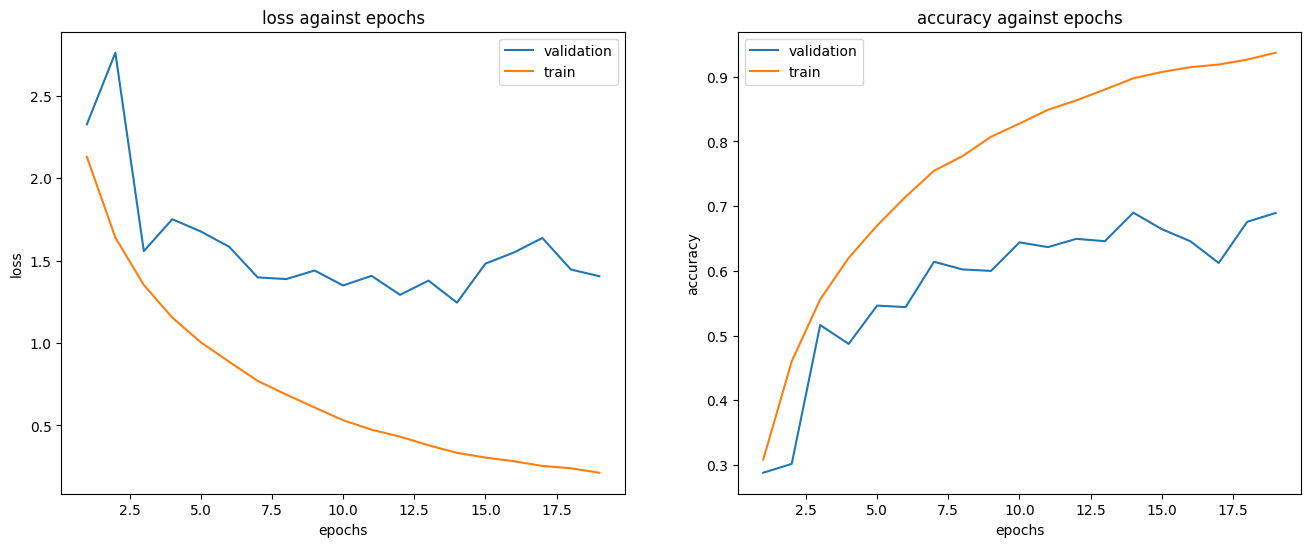

{'activation': <keras.layers.activation.relu.ReLU object at 0x00000215F20D6AC0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000021596637040>, 'dropout': 0.1, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 32, 'n': 3, 'padding': 'same', 'strides': (1, 1)}


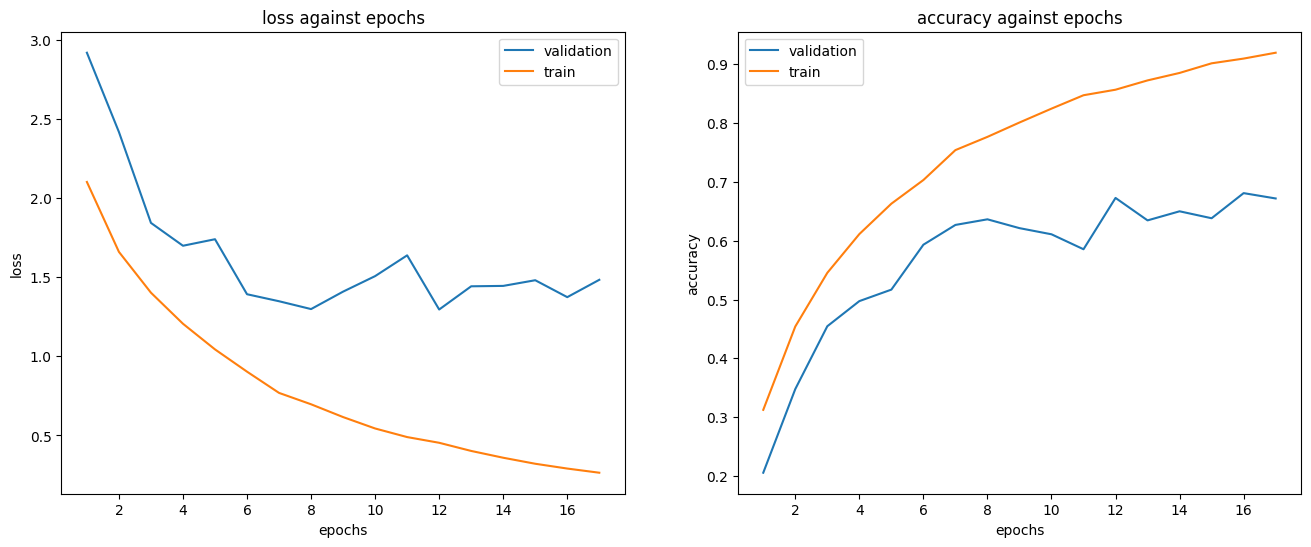

{'activation': <keras.layers.activation.relu.ReLU object at 0x00000215F20D6AC0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000021596637040>, 'dropout': 0.1, 'kernel_size': (7, 7), 'm': 1, 'max_neurons': 64, 'n': 3, 'padding': 'same', 'strides': (1, 1)}


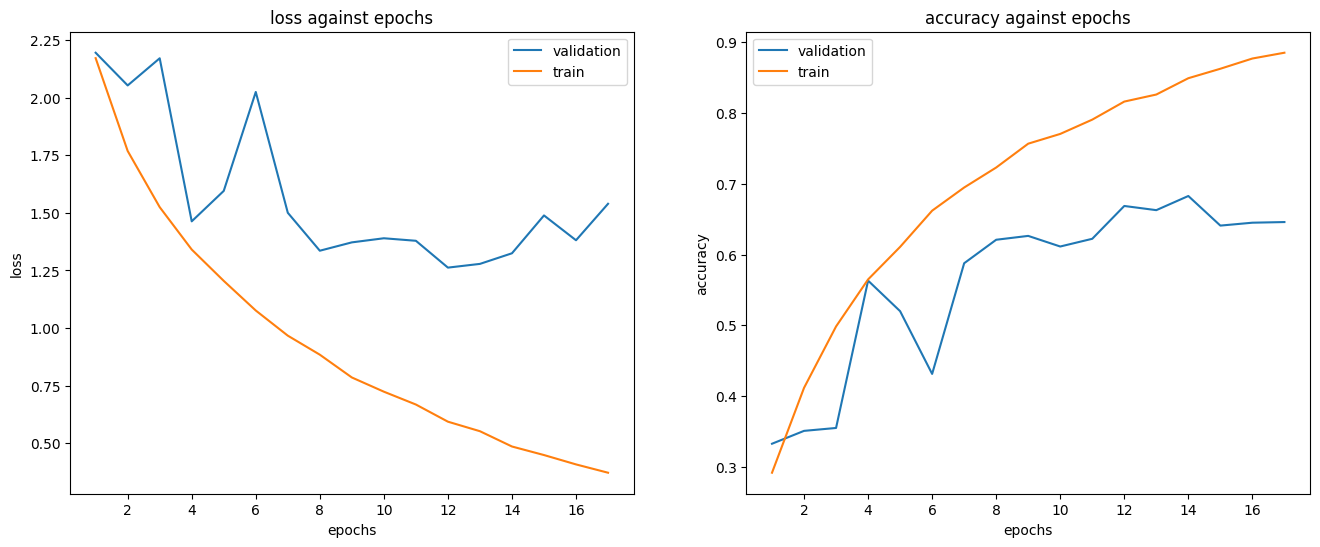

{'activation': <keras.layers.activation.relu.ReLU object at 0x00000215F20D6AC0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000021596637040>, 'dropout': 0.1, 'kernel_size': (7, 7), 'm': 1, 'max_neurons': 32, 'n': 3, 'padding': 'same', 'strides': (1, 1)}


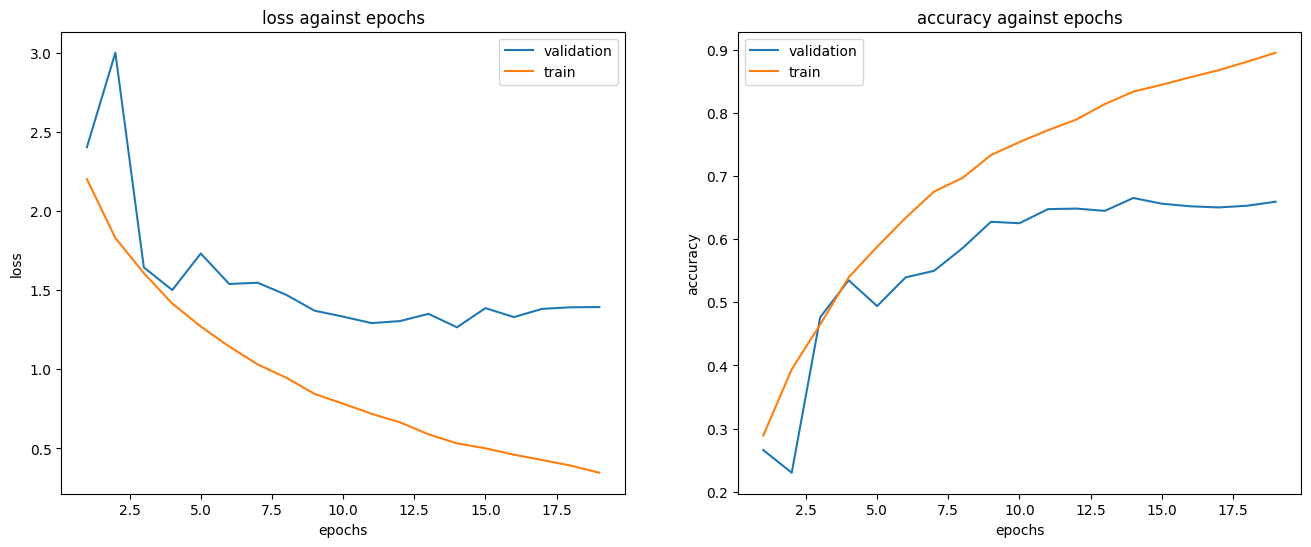

{'activation': <keras.layers.activation.relu.ReLU object at 0x00000215F20D6AC0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000021596637040>, 'dropout': 0.1, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 32, 'n': 2, 'padding': 'same', 'strides': (1, 1)}


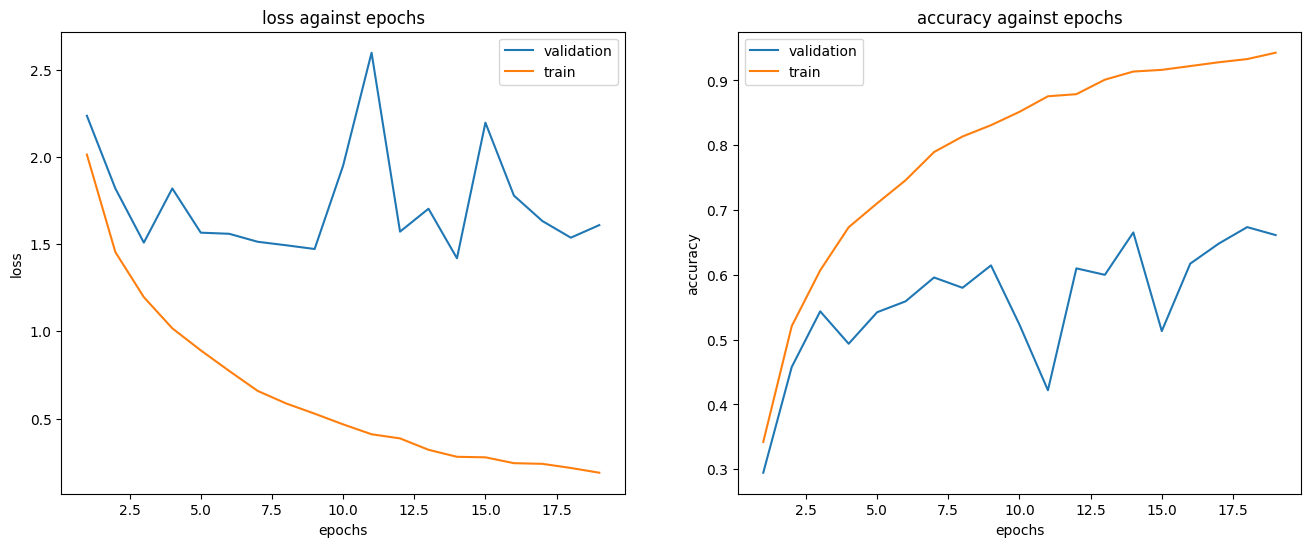

In [29]:
top_5_indexes = np.argsort(val_accuracies)[-5:][::-1]


for i in top_5_indexes:
  validation_loss = fit_results[i]['val_loss']
  validation_accuracy = fit_results[i]['val_accuracy']

  train_loss = fit_results[i]['loss']
  train_accuracy = fit_results[i]['accuracy']

  epochs = range(1 , len(validation_accuracy) + 1)

  fig , ax = plt.subplots(1 , 2 , figsize=(16 , 6 ,))

  print(successful_params[i])

  # loss
  ax[0].plot(epochs , validation_loss, label='validation')
  ax[0].plot(epochs , train_loss, label='train')
  ax[0].legend()
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('loss')
  ax[0].set_title('loss against epochs')

  # acc
  ax[1].plot(epochs , validation_accuracy, label='validation')
  ax[1].plot(epochs , train_accuracy, label='train')
  ax[1].legend()
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('accuracy')
  ax[1].set_title('accuracy against epochs')
  plt.show()


In [45]:
# Hyper tuning amount of data fed into the model

for i in top_5_indexes:
  params = successful_params[i]
  epochs = len(fit_results[i]['loss'])
  epochs_range = range(1 , len(fit_results[i]['loss']) + 1)
  
  splits = [0.25 , 0.5 , 0.75 , 1]
  for split in splits:
    print(f'Traing {params}\n on {split} of data')
    X_train_split , _ ,y_train_split , _ = train_test_split(X_train , y_train, random_state=42 , train_size=split , stratify=y_train)
    X_train_split = np.asarray(X_train_split, dtype=np.float32)
    y_train_split = np.asarray(y_train_split, dtype=np.float32)
    X_validation = np.asarray(X_validation, dtype=np.float32)
    y_validation = np.asarray(y_validation, dtype=np.float32)


    model = create_model(**params)
    history = model.fit(X_train_split , y_train_split , epochs=epochs, batch_size=16, validation_data=(X_validation , y_validation))

    val_loss , val_accuracy = model.evaluate(X_validation , y_validation)
    print(f'Validation Loss: {val_loss}')
    print(f'Validation accuracy: {val_accuracy}')

    # Plotting graph
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']

    # loss
    ax[0].plot(epochs_range , validation_loss, label='validation')
    ax[0].plot(epochs_range , train_loss, label='train')
    ax[0].legend()
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    ax[0].set_title('loss against epochs')

    # acc
    ax[1].plot(epochs_range , validation_accuracy, label='validation')
    ax[1].plot(epochs_range , train_accuracy, label='train')
    ax[1].legend()
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].set_title('accuracy against epochs')
    plt.show()





Traing {'activation': <keras.layers.activation.relu.ReLU object at 0x00000215F20D6AC0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000021596637040>, 'dropout': 0.1, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 256, 'n': 3, 'padding': 'same', 'strides': (1, 1)}
 on 0.25 of data


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.